## 主題: Amazon Fine Food Reviews
## 分類器: CNN, LSTM

## About Dataset

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.      
  

    
## HW4
>- 本次作業為情緒分析，資料集為Amazon Fine Food Reviews 的Reviews.csv
>- https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
 
 
  

## 1. 資料前處理


### 1-1 讀取資料
- 讀取csv檔前 10000 筆資料
- 僅保留Text、Score兩個欄位

In [1]:
import pandas as pd

# 主要使用 Reviews.csv這份資料
data = pd.read_csv("Reviews.csv", header=0, usecols=["Text","Score"], encoding='utf-8')[:10000]  #train
testData = pd.read_csv("test.csv", header=0, usecols=["Text"], encoding='utf-8')         # test

data.tail()

,Score,Text
9995,1,we switched from the advance similac to the or...
9996,5,"Like the bad reviews say, the organic formula ..."
9997,5,I wanted to solely breastfeed but was unable t...
9998,5,i love the fact that i can get this delieved t...
9999,4,We have a 7 week old... He had gas and constip...


### 1-2 資料轉換
- 將Score欄位內值大於等於4的轉成1(positive), 其餘轉成0 (negative)

    


In [2]:
data.loc[data['Score']<4,'Score']=0
data.loc[data['Score']>=4,'Score']=1
data.head()

,Score,Text
0,1,I have bought several of the Vitality canned d...
1,0,Product arrived labeled as Jumbo Salted Peanut...
2,1,This is a confection that has been around a fe...
3,0,If you are looking for the secret ingredient i...
4,1,Great taffy at a great price. There was a wid...


### 1-3 去除停用字

In [20]:
import nltk  #使用Nature Language Tool Kit (NLTK)進行文本處理
import string

####文本清理####
def text_preprocessing(text):
       
    text = text.translate(str.maketrans('', '', string.punctuation))  #刪去標點符號
    text = text.lower() # 統一轉為小寫

    sentences = nltk.sent_tokenize(text) # 斷句 
    tokens = [nltk.tokenize.word_tokenize(sent) for sent in sentences]  # 斷詞
    
    nltk_stopwords = nltk.corpus.stopwords.words("english")
    tokens = [token for token in tokens[0] if token not in nltk_stopwords] # 僅保留非停用字(去除停用字)
        
    return tokens # 需要回傳list

In [21]:

train_cleaned = []  # 清乾淨的train data
test_cleaned = []  # 清乾淨的test data
vocab = []  # 給模型的資料集

for text in data['Text']:
    
    t = text_preprocessing(text)
    train_cleaned.append(t) 
    vocab.extend(t) # 只加入list內的元素而非整個[list]
 
 

### 1-4 文字轉向量
訓練模型前要將文字轉為機器可閱讀的形式，以前使用的one-hot/dummy會造成高維稀疏的向量矩陣，因此採計算詞向量的方法 
 

In [14]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [19]:
max_features = 5000   # 指定進入當特徵的字有幾個
tokenizer = Tokenizer(num_words = max_features) #使用keras tokenizer把詞彙轉為向量
tokenizer.fit_on_texts(train_cleaned)
list_tokens = tokenizer.texts_to_sequences(train_cleaned)

max_len = 150 #每段文字<=150個字
text_train = pad_sequences(list_tokens, maxlen = max_len) #截長補短
label_train = data['Score']

text_train

array([[   0,    0,    0, ...,  340,   13,   70],
       [   0,    0,    0, ...,    2, 3552,  121],
       [ 408,  553,  133, ...,  150,  150,  175],
       ...,
       [   0,    0,    0, ...,   15,  380,   33],
       [  77,  277,  380, ...,  387,   21,  168],
       [   0,  326,  110, ...,   72,  685, 2529]], dtype=int32)

## 2. 建立模型

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs


### 2.1 holdout method

In [22]:
from sklearn.model_selection import train_test_split

sentences_train, sentences_test, y_train, y_test = train_test_split(
   text_train, label_train, test_size=0.2, random_state=1000)

### 2.2 plot Accuracy&Loss 

In [52]:
import matplotlib.pyplot as plt

# 宣告 function plot出訓練過程中的Accuracy與Loss值變化
def show_train_history(train, val, y_label, title): #依傳入的不同分別可繪製loss, accuracy
    plt.figure(figsize=(7, 4))  #展開畫布
    plt.plot(train_history.history[train]) #繪製train_loss/accuracy
    plt.plot(train_history.history[val]) #繪製val_loss/accuracy
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

# CNN

In [53]:
textcnnmodel = Sequential()
textcnnmodel.add(Embedding(output_dim=32, input_dim=5000, input_length=50))
textcnnmodel.add(Conv1D(128, 5, activation='relu'))
textcnnmodel.add(GlobalMaxPooling1D())
textcnnmodel.add(Dense(10, activation='relu'))
textcnnmodel.add(Dropout(0.7))
textcnnmodel.add(Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam', 
               loss='binary_crossentropy', 
               metrics=['accuracy'])
textcnnmodel.summary() 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_5 (Conv1D)           (None, 46, 128)           20608     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 10)                1290      
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                      

Epoch 1/30
57/57 [==============================] - 1s 8ms/step - loss: 0.5995 - accuracy: 0.7549 - val_loss: 0.5526 - val_accuracy: 0.7525
Epoch 2/30
57/57 [==============================] - 0s 6ms/step - loss: 0.5551 - accuracy: 0.7624 - val_loss: 0.4967 - val_accuracy: 0.7525
Epoch 3/30
57/57 [==============================] - 0s 6ms/step - loss: 0.4858 - accuracy: 0.7699 - val_loss: 0.4247 - val_accuracy: 0.7638
Epoch 4/30
57/57 [==============================] - 0s 6ms/step - loss: 0.4169 - accuracy: 0.8051 - val_loss: 0.3750 - val_accuracy: 0.8400
Epoch 5/30
57/57 [==============================] - 0s 6ms/step - loss: 0.3532 - accuracy: 0.8476 - val_loss: 0.3647 - val_accuracy: 0.8350
Epoch 6/30
57/57 [==============================] - 0s 6ms/step - loss: 0.2874 - accuracy: 0.8744 - val_loss: 0.4020 - val_accuracy: 0.8400
Epoch 7/30
57/57 [==============================] - 0s 6ms/step - loss: 0.2549 - accuracy: 0.8893 - val_loss: 0.4046 - val_accuracy: 0.8288
Epoch 8/30
57/57 [==

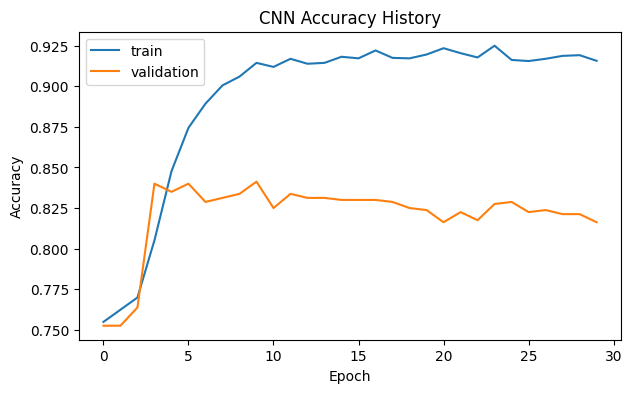

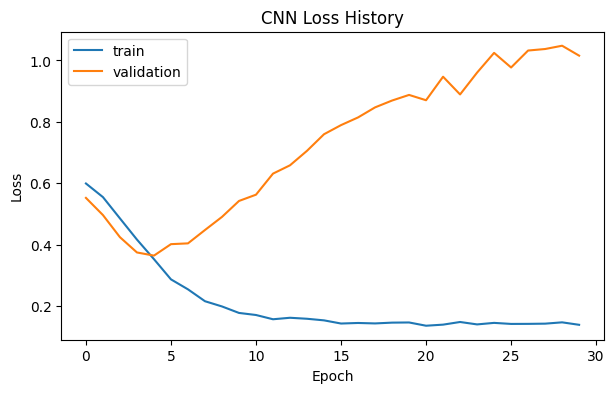

63/63 [==============================] - 0s 1ms/step - loss: 1.0377 - accuracy: 0.8385
CNN Accuracy： 0.8385000228881836


In [54]:
 # 定義訓練模型
textcnnmodel.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])


# 模型訓練
train_history = textcnnmodel.fit(sentences_train, y_train,
         epochs=30, 
         batch_size=128,
         verbose=1,
         validation_split=0.1)

# 畫出accuracy圖
show_train_history('accuracy', 'val_accuracy', "Accuracy", "CNN Accuracy History")
show_train_history('loss', 'val_loss', "Loss", "CNN Loss History")

# 準確率
scores = textcnnmodel.evaluate(sentences_test, y_test,verbose=1)
print("CNN Accuracy：",scores[1])

# LSTM Model

In [55]:
from keras.models import Sequential
from keras.layers.core import Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import LSTM

LSTMmodel = Sequential() #建立模型
LSTMmodel .add(Embedding(output_dim=32, input_dim=5000, input_length=50)) 
#輸出的維度是32，希望將數字list轉換為32維度的向量
#輸入的維度是3800，也就是我們之前建立的字典是5000字
#數字list截長補短後都是50個數字

LSTMmodel .add(Dropout(0.5)) #隨機在神經網路中放棄20%的神經元，避免overfitting

#建立LSTM層
LSTMmodel .add(LSTM(32)) 
#建立32個神經元的LSTM層

#建立隱藏層
LSTMmodel .add(Dense(units=256,activation='relu')) 
#建立256個神經元的隱藏層
LSTMmodel .add(Dropout(0.5))

#建立輸出層
LSTMmodel .add(Dense(units=1,activation='sigmoid'))
 #建立一個神經元的輸出層

LSTMmodel .summary()



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 32)            160000    
                                                                 
 dropout_9 (Dropout)         (None, 50, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_14 (Dense)            (None, 256)               8448      
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 177,025
Trainable params: 177,025
Non-t

Epoch 1/30
57/57 [==============================] - 3s 19ms/step - loss: 0.5718 - accuracy: 0.7582 - val_loss: 0.5234 - val_accuracy: 0.7525
Epoch 2/30
57/57 [==============================] - 1s 14ms/step - loss: 0.4003 - accuracy: 0.8094 - val_loss: 0.3446 - val_accuracy: 0.8450
Epoch 3/30
57/57 [==============================] - 1s 14ms/step - loss: 0.2641 - accuracy: 0.8925 - val_loss: 0.3496 - val_accuracy: 0.8512
Epoch 4/30
57/57 [==============================] - 1s 14ms/step - loss: 0.1985 - accuracy: 0.9231 - val_loss: 0.3672 - val_accuracy: 0.8612
Epoch 5/30
57/57 [==============================] - 1s 14ms/step - loss: 0.1579 - accuracy: 0.9406 - val_loss: 0.4196 - val_accuracy: 0.8600
Epoch 6/30
57/57 [==============================] - 1s 14ms/step - loss: 0.1223 - accuracy: 0.9553 - val_loss: 0.4597 - val_accuracy: 0.8525
Epoch 7/30
57/57 [==============================] - 1s 14ms/step - loss: 0.1049 - accuracy: 0.9635 - val_loss: 0.4588 - val_accuracy: 0.8562
Epoch 8/30
57

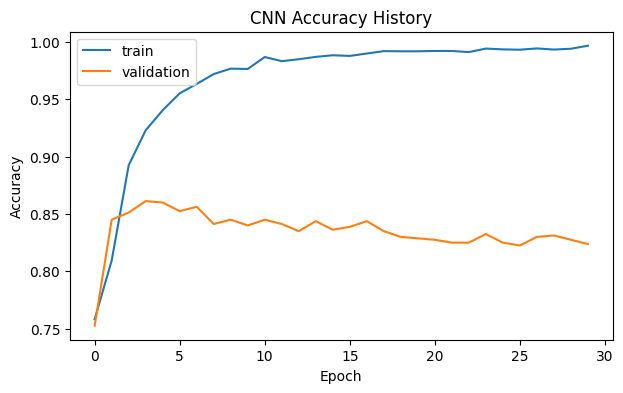

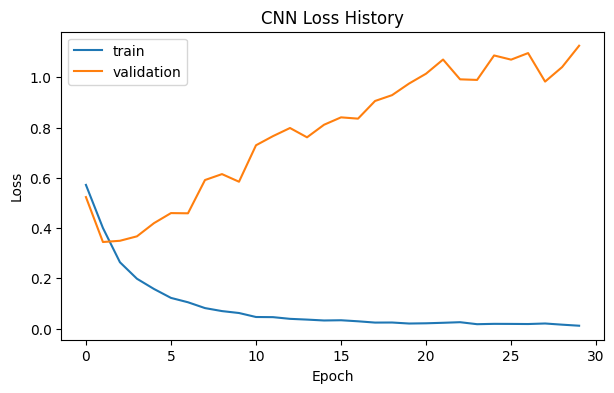

63/63 [==============================] - 0s 3ms/step - loss: 1.1162 - accuracy: 0.8340
CNN Accuracy： 0.8339999914169312


In [56]:
 # 定義訓練模型
LSTMmodel.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])


# 模型訓練
train_history = LSTMmodel.fit(sentences_train, y_train,
         epochs=30, 
         batch_size=128,
         verbose=1,
         validation_split=0.1)

# 畫出accuracy圖
show_train_history('accuracy', 'val_accuracy', "Accuracy", "CNN Accuracy History")
show_train_history('loss', 'val_loss', "Loss", "CNN Loss History")

# 準確率
scores = LSTMmodel.evaluate(sentences_test, y_test,verbose=1)
print("CNN Accuracy：",scores[1])

# 結果討論
### 方法比較
- 可以看出LSTM的結果較好，透過memory和forget單元的設計可以有效地去做文字的情感分類
- CNN可能更擅長去學習具有明確特徵的文檔

### 架構設計
- conv: filter在文字向量上移動去擷取特徵
- pooling: maxpooling將該區域的特徵取出最大值，降低運算量
- dropout: 丟棄一部分資訊避免overfitting

### dropout layer
- overfitting的狀況比較嚴重，可以看到Train_loss平緩下降，但val_loss上升，設置了dropout可以改善但是可能模型的敏感度過高導致overfitting